## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file 
f = open("C://Users//sebas//Case Study NLP//complaints.json","r")# Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [3]:
# Inspect the dataframe to understand the given data.
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [4]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [5]:
#Assign new column names

new_names = []
for col in df.columns:
    name = col[1:]
    new_names.append(name)

name_change_d = dict(zip(list(df.columns), new_names))
df.rename(columns=name_change_d, inplace=True)    
    
print(df.columns)

Index(['index', 'type', 'id', 'score', 'source.tags', 'source.zip_code',
       'source.complaint_id', 'source.issue', 'source.date_received',
       'source.state', 'source.consumer_disputed', 'source.product',
       'source.company_response', 'source.company', 'source.submitted_via',
       'source.date_sent_to_company', 'source.company_public_response',
       'source.sub_product', 'source.timely', 'source.complaint_what_happened',
       'source.sub_issue', 'source.consumer_consent_provided'],
      dtype='object')


In [6]:
#Assign nan in place of blanks in the complaints column
df['complaints'] = df['source.complaint_what_happened'].replace(r'', np.nan, regex=True)

In [7]:
#Remove all rows where complaints column is nan
#df.drop(columns = ['source.complaint_what_happened'])
df = df[~df['complaints'].isna()]
df

,index,type,id,score,source.tags,source.zip_code,source.complaint_id,source.issue,source.date_received,source.state,...,source.company,source.submitted_via,source.date_sent_to_company,source.company_public_response,source.sub_product,source.timely,source.complaint_what_happened,source.sub_issue,source.consumer_consent_provided,complaints
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,Good morning my name is XXXX XXXX and I apprec...
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,I upgraded my XXXX XXXX card in XX/XX/2018 and...
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided,Chase Card was reported on XX/XX/2019. However...
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided,"On XX/XX/2018, while trying to book a XXXX XX..."
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided,my grand son give me check for {$1600.00} i de...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78303,complaint-public-v2,complaint,3094545,0.0,Older American,281XX,3094545,"Advertising and marketing, including promotion...",2018-12-07T12:00:00-05:00,NC,...,JPMORGAN CHASE & CO.,Web,2018-12-07T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,After being a Chase Card customer for well ove...,Didn't receive advertised or promotional terms,Consent provided,After being a Chase Card customer for well ove...
78309,complaint-public-v2,complaint,3091984,0.0,None,934XX,3091984,"Other features, terms, or problems",2018-12-05T12:00:00-05:00,CA,...,JPMORGAN CHASE & CO.,Web,2018-12-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Other problem,Consent provided,"On Wednesday, XX/XX/XXXX I called Chas, my XXX..."
78310,complaint-public-v2,complaint,3133355,0.0,None,923XX,3133355,Problem with a lender or other company chargin...,2019-01-25T12:00:00-05:00,CA,...,JPMORGAN CHASE & CO.,Web,2019-01-25T12:00:00-05:00,None,Checking account,Yes,I am not familiar with XXXX pay and did not un...,Transaction was not authorized,Consent provided,I am not familiar with XXXX pay and did not un...
78311,complaint-public-v2,complaint,3110963,0.0,None,None,3110963,"Other features, terms, or problems",2018-12-27T12:00:00-05:00,PA,...,JPMORGAN CHASE & CO.,Web,2018-12-27T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I have had flawless credit for 30 yrs. I've ha...,Problem with balance transfer,Consent provided,I have had flawless credit for 30 yrs. I've ha...


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [8]:
# Write your function here to clean the text and remove all the unnecessary elements.
def text_cleaner (text):
    text = text.lower() #make the text lowercase
    text = re.sub(r'\([{^)}]*\)', '', text) #remove text in square brackets
    text = ''.join(char for char in text if char not in string.punctuation) # remove punctuation
    text = ''.join(char for char in text if not char.isdigit()) #remove words containing numbers
    return text

df['complaints_cleaned'] = df['complaints'].apply(lambda x: text_cleaner(x))
df['complaints_cleaned']

1        good morning my name is xxxx xxxx and i apprec...
2        i upgraded my xxxx xxxx card in xxxx and was t...
10       chase card was reported on xxxx however fraudu...
11       on xxxx while trying to book a xxxx  xxxx  tic...
14       my grand son give me check for  i deposit it i...
                               ...                        
78303    after being a chase card customer for well ove...
78309    on wednesday xxxxxxxx i called chas my xxxx xx...
78310    i am not familiar with xxxx pay and did not un...
78311    i have had flawless credit for  yrs ive had ch...
78312    roughly  years ago i closed out my accounts wi...
Name: complaints_cleaned, Length: 21072, dtype: object

In [9]:
#Write your function to Lemmatize the texts
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
df['complaints_lemmatized'] = df['complaints_cleaned'].apply(lemmatizer.lemmatize)

In [10]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df[['complaints', 'complaints_lemmatized']]

In [11]:
df_clean

,complaints,complaints_lemmatized
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in xxxx and was t...
10,Chase Card was reported on XX/XX/2019. However...,chase card was reported on xxxx however fraudu...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on xxxx while trying to book a xxxx xxxx tic...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...
...,...,...
78303,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx i called chas my xxxx xx...
78310,I am not familiar with XXXX pay and did not un...,i am not familiar with xxxx pay and did not un...
78311,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for yrs ive had ch...


In [12]:
#Write your function to extract the POS tags 

def pos_tag(text):
  # write your code here
    tokens = nltk.word_tokenize(text)
    word_list = []
    for idx, tuple_ in enumerate(nltk.pos_tag(tokens)):
        if tuple_[-1] == "NN":
            word_list.append(tuple_[0])
    return ' '.join(word_list)

#df_clean["complaint_POS_removed"] =  #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
#df_clean["complaint_POS_removed"] = [df_clean['complaints_lemmatized'].apply(lambda x: pos_tag(x))
#[word for idx, tuple_ in enumerate(df_clean['complaints_lemmatized'].apply(lambda x: pos_tag(x))) for word, tag in tuple_ if tag == 'NN']
df_clean.loc[:,"complaint_POS_removed"] = df_clean.loc[:,'complaints_lemmatized'].apply(lambda x: pos_tag(x))

C:\Users\sebas\anaconda3\envs\nlp_env\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [13]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaints,complaints_lemmatized,complaint_POS_removed
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember debt verific...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in xxxx and was t...,i card agent upgrade date agent information or...
10,Chase Card was reported on XX/XX/2019. However...,chase card was reported on xxxx however fraudu...,card xxxx application identity consent credit ...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on xxxx while trying to book a xxxx xxxx tic...,book xxxx ticket i offer ticket card i informa...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...,son deposit chase account fund chase bank acco...
...,...,...,...
78303,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade credit chase airlin...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx i called chas my xxxx xx...,xxxxxxxx i chas visa credit card provider clai...
78310,I am not familiar with XXXX pay and did not un...,i am not familiar with xxxx pay and did not un...,i pay risk bank app chase mobile banking i mer...
78311,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for yrs ive had ch...,i credit credit chase freedom xxxx balance lif...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [14]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean["complaint_POS_removed"]

1        morning name stop bank cardmember debt verific...
2        i card agent upgrade date agent information or...
10       card xxxx application identity consent credit ...
11       book xxxx ticket i offer ticket card i informa...
14       son deposit chase account fund chase bank acco...
                               ...                        
78303    chase card customer decade credit chase airlin...
78309    xxxxxxxx i chas visa credit card provider clai...
78310    i pay risk bank app chase mobile banking i mer...
78311    i credit credit chase freedom xxxx balance lif...
78312    jp bank xxxx order line credit i i account pay...
Name: complaint_POS_removed, Length: 21072, dtype: object

#### Find the top 40 words by frequency among all the articles after processing the text.

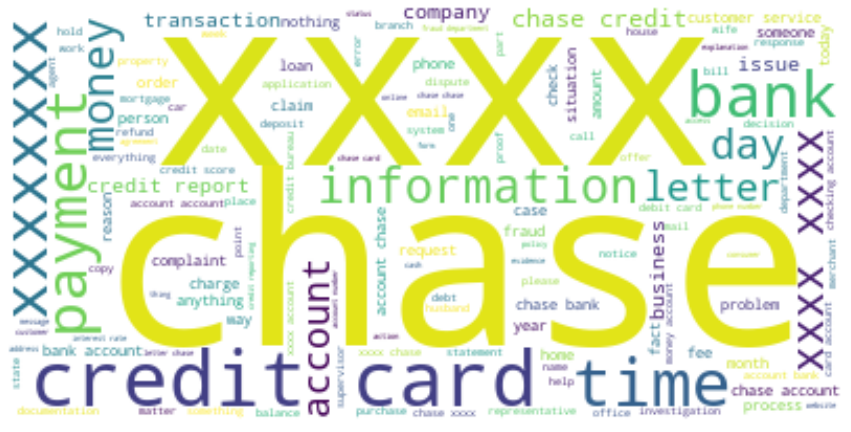

In [15]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud

text = " ".join(word for word in df_clean["complaint_POS_removed"])
stopwords = set(nltk.corpus.stopwords.words('english'))
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [16]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

C:\Users\sebas\AppData\Local\Temp/ipykernel_16504/3655474111.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [17]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
from collections import Counter

text = ' '.join(df_clean['Complaint_clean'])

token = nltk.word_tokenize(text)
print(Counter(token).most_common(30))

[('i', 126779), ('chase', 51850), ('xxxx', 44623), ('account', 41085), ('credit', 32678), ('bank', 26650), ('card', 26061), ('payment', 13972), ('xxxxxxxx', 13408), ('time', 11973), ('money', 11946), ('loan', 10012), ('information', 9649), ('letter', 8435), ('check', 8248), ('mortgage', 7937), ('number', 7750), ('amount', 7572), ('phone', 7501), ('balance', 7138), ('fraud', 7061), ('company', 6495), ('customer', 6439), ('report', 6120), ('charge', 5793), ('day', 5673), ('business', 5463), ('service', 5372), ('interest', 5239), ('home', 5092)]


In [18]:
#Print the top 10 words in the unigram frequency
print(Counter(token).most_common(10))

[('i', 126779), ('chase', 51850), ('xxxx', 44623), ('account', 41085), ('credit', 32678), ('bank', 26650), ('card', 26061), ('payment', 13972), ('xxxxxxxx', 13408), ('time', 11973)]


In [19]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
from nltk.util import ngrams
bigrams = ngrams(token,2)
Counter(bigrams).most_common(30)

[(('credit', 'card'), 10996),
 (('xxxx', 'i'), 9164),
 (('i', 'i'), 9130),
 (('i', 'chase'), 8477),
 (('account', 'i'), 6098),
 (('xxxxxxxx', 'i'), 5343),
 (('xxxx', 'xxxx'), 4781),
 (('i', 'account'), 4394),
 (('i', 'xxxx'), 4264),
 (('i', 'credit'), 4114),
 (('i', 'bank'), 3768),
 (('card', 'i'), 3694),
 (('chase', 'i'), 3637),
 (('chase', 'credit'), 3309),
 (('credit', 'report'), 3263),
 (('customer', 'service'), 3023),
 (('chase', 'bank'), 3014),
 (('chase', 'account'), 2878),
 (('bank', 'account'), 2627),
 (('account', 'chase'), 2367),
 (('i', 'card'), 2260),
 (('i', 'payment'), 2257),
 (('time', 'i'), 2204),
 (('bank', 'i'), 2182),
 (('account', 'account'), 1996),
 (('i', 'letter'), 1915),
 (('i', 'money'), 1905),
 (('account', 'xxxx'), 1770),
 (('money', 'i'), 1738),
 (('xxxx', 'chase'), 1712)]

In [20]:
#Print the top 10 words in the bigram frequency
Counter(bigrams).most_common(10)

[]

In [21]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
trigrams = ngrams(token,3)

In [22]:
#Print the top 10 words in the trigram frequency
Counter(trigrams).most_common(10)

[(('chase', 'credit', 'card'), 1878),
 (('i', 'credit', 'card'), 1604),
 (('credit', 'card', 'i'), 1209),
 (('xxxx', 'xxxx', 'i'), 1000),
 (('credit', 'card', 'company'), 804),
 (('credit', 'card', 'account'), 765),
 (('i', 'xxxx', 'i'), 753),
 (('i', 'i', 'i'), 751),
 (('i', 'customer', 'service'), 751),
 (('xxxx', 'i', 'chase'), 737)]

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [23]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

C:\Users\sebas\AppData\Local\Temp/ipykernel_16504/619742717.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [24]:
#All masked texts has been removed
df_clean

,complaints,complaints_lemmatized,complaint_POS_removed,Complaint_clean
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember debt verific...,morning name stop bank cardmember debt verific...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in xxxx and was t...,i card agent upgrade date agent information or...,i card agent upgrade date agent information or...
10,Chase Card was reported on XX/XX/2019. However...,chase card was reported on xxxx however fraudu...,card xxxx application identity consent credit ...,card application identity consent credit iden...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on xxxx while trying to book a xxxx xxxx tic...,book xxxx ticket i offer ticket card i informa...,book ticket i offer ticket card i information...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...,son deposit chase account fund chase bank acco...,son deposit chase account fund chase bank acco...
...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade credit chase airlin...,chase card customer decade credit chase airlin...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx i called chas my xxxx xx...,xxxxxxxx i chas visa credit card provider clai...,i chas visa credit card provider claim purcha...
78310,I am not familiar with XXXX pay and did not un...,i am not familiar with xxxx pay and did not un...,i pay risk bank app chase mobile banking i mer...,i pay risk bank app chase mobile banking i mer...
78311,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for yrs ive had ch...,i credit credit chase freedom xxxx balance lif...,i credit credit chase freedom balance life pl...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [25]:
#Write your code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer()

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [26]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
X = tfidf.fit_transform(df_clean['Complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [27]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [28]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=5) #write your code here

In [29]:
nmf_model.fit(X)
len(tfidf.get_feature_names_out())

C:\Users\sebas\anaconda3\envs\nlp_env\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



15155

In [30]:
#Print the Top15 words for each of the topics
components_df = pd.DataFrame(nmf_model.components_, columns=tfidf.get_feature_names_out())

for topic in range(components_df.shape[0]):
    tmp = components_df.iloc[topic]
    print(f'For topic {topic+1} the words with the highest value are:')
    print(tmp.nlargest(15))
    print('\n')

For topic 1 the words with the highest value are:
account        4.155989
bank           2.435065
money          1.690643
check          1.620016
chase          1.374045
branch         0.749372
deposit        0.664719
number         0.583774
fraud          0.556457
business       0.556068
checking       0.533533
transaction    0.506982
claim          0.496715
day            0.441849
information    0.439030
Name: 0, dtype: float64


For topic 2 the words with the highest value are:
card        3.399676
chase       1.495044
credit      1.151349
charge      0.866516
dispute     0.541784
fraud       0.537679
company     0.426862
merchant    0.417855
purchase    0.368407
fee         0.361060
letter      0.354157
time        0.350264
phone       0.349309
service     0.346133
number      0.342577
Name: 1, dtype: float64


For topic 3 the words with the highest value are:
loan            2.428789
mortgage        1.957512
chase           1.074851
home            0.937081
modification    0.92089

In [31]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_list = ['account','card','loan','credit','payment']

In [32]:
#Assign the best topic to each of the cmplaints in Topic Column

#df_clean['Topic'] = topic_list#write your code to assign topics to each rows.
df_clean['Topic'] = nmf_model.transform(X).argmax(axis=1)

C:\Users\sebas\AppData\Local\Temp/ipykernel_16504/1752044549.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [33]:
df_clean

,complaints,complaints_lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember debt verific...,morning name stop bank cardmember debt verific...,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in xxxx and was t...,i card agent upgrade date agent information or...,i card agent upgrade date agent information or...,1
10,Chase Card was reported on XX/XX/2019. However...,chase card was reported on xxxx however fraudu...,card xxxx application identity consent credit ...,card application identity consent credit iden...,3
11,"On XX/XX/2018, while trying to book a XXXX XX...",on xxxx while trying to book a xxxx xxxx tic...,book xxxx ticket i offer ticket card i informa...,book ticket i offer ticket card i information...,3
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...,son deposit chase account fund chase bank acco...,son deposit chase account fund chase bank acco...,0
...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade credit chase airlin...,chase card customer decade credit chase airlin...,3
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx i called chas my xxxx xx...,xxxxxxxx i chas visa credit card provider clai...,i chas visa credit card provider claim purcha...,1
78310,I am not familiar with XXXX pay and did not un...,i am not familiar with xxxx pay and did not un...,i pay risk bank app chase mobile banking i mer...,i pay risk bank app chase mobile banking i mer...,1
78311,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for yrs ive had ch...,i credit credit chase freedom xxxx balance lif...,i credit credit chase freedom balance life pl...,4


In [34]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

,complaints,complaints_lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember debt verific...,morning name stop bank cardmember debt verific...,0
24,mishandling of this account by Chase auto and ...,mishandling of this account by chase auto and ...,mishandling account auto xxxx,mishandling account auto,0
17,With out notice J.P. Morgan Chase restricted m...,with out notice jp morgan chase restricted my ...,jp chase account debit card tuesday i branch c...,jp chase account debit card tuesday i branch c...,0
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...,son deposit chase account fund chase bank acco...,son deposit chase account fund chase bank acco...,0
27,I opened an account with chase bank on XXXX an...,i opened an account with chase bank on xxxx an...,i account bank xxxx code bonus i everything ac...,i account bank code bonus i everything accoun...,0
32,My chase amazon card was declined for a cateri...,my chase amazon card was declined for a cateri...,chase card catering order i amount i chase tod...,chase card catering order i amount i chase tod...,1
21,"On XXXX XX/XX/2019, I made a {$300.00} payment...",on xxxx xxxx i made a payment to an online re...,i payment retailer pay xxxx chase website i we...,i payment retailer pay chase website i websit...,1
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in xxxx and was t...,i card agent upgrade date agent information or...,i card agent upgrade date agent information or...,1
48,"JP Morgan Chase Bank, please answer the follow...",jp morgan chase bank please answer the followi...,jp bank please chase information reason inform...,jp bank please chase information reason inform...,1
40,"XXXX XXXX a sofa, love seat, table and chairs ...",xxxx xxxx a sofa love seat table and chairs an...,xxxx love seat table debit card bank claim fur...,love seat table debit card bank claim furnitu...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [35]:
#Create the dictionary of Topic names and Topics

Topic_names = {0:'bank Account',1:'CC', 2:'theft', 3:'mortgage',4:'others'}
#Replace Topics with Topic Names
df_clean['Topic_Names'] = df_clean['Topic'].map(Topic_names)

C:\Users\sebas\AppData\Local\Temp/ipykernel_16504/1409965340.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [36]:
df_clean

,complaints,complaints_lemmatized,complaint_POS_removed,Complaint_clean,Topic,Topic_Names
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember debt verific...,morning name stop bank cardmember debt verific...,0,bank Account
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in xxxx and was t...,i card agent upgrade date agent information or...,i card agent upgrade date agent information or...,1,CC
10,Chase Card was reported on XX/XX/2019. However...,chase card was reported on xxxx however fraudu...,card xxxx application identity consent credit ...,card application identity consent credit iden...,3,mortgage
11,"On XX/XX/2018, while trying to book a XXXX XX...",on xxxx while trying to book a xxxx xxxx tic...,book xxxx ticket i offer ticket card i informa...,book ticket i offer ticket card i information...,3,mortgage
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...,son deposit chase account fund chase bank acco...,son deposit chase account fund chase bank acco...,0,bank Account
15,Can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,3,mortgage
17,With out notice J.P. Morgan Chase restricted m...,with out notice jp morgan chase restricted my ...,jp chase account debit card tuesday i branch c...,jp chase account debit card tuesday i branch c...,0,bank Account
20,"During the summer months, I experience a decli...",during the summer months i experience a declin...,summer income employment month payment extensi...,summer income employment month payment extensi...,4,others
21,"On XXXX XX/XX/2019, I made a {$300.00} payment...",on xxxx xxxx i made a payment to an online re...,i payment retailer pay xxxx chase website i we...,i payment retailer pay chase website i websit...,1,CC
23,I have a Chase credit card which is incorrectl...,i have a chase credit card which is incorrectl...,chase credit card credit report company issue,chase credit card credit report company issue,3,mortgage


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [37]:
#Create the dictionary again of Topic names and Topics

#Topic_names = {0:'bank Account',1:'CC', 2:'theft', 3:'mortgage',4:'others'}
#Replace Topics with Topic Names
#df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [38]:
#df_clean

In [39]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['Complaint_clean','Topic']]

In [40]:
training_data

,Complaint_clean,Topic
1,morning name stop bank cardmember debt verific...,0
2,i card agent upgrade date agent information or...,1
10,card application identity consent credit iden...,3
11,book ticket i offer ticket card i information...,3
14,son deposit chase account fund chase bank acco...,0
15,inquiry,3
17,jp chase account debit card tuesday i branch c...,0
20,summer income employment month payment extensi...,4
21,i payment retailer pay chase website i websit...,1
23,chase credit card credit report company issue,3


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [43]:

#Write your code to get the Vector count
countvect = CountVectorizer()
X_countvect= countvect.fit_transform(df_clean['Complaint_clean'])

#Write your code here to transform the word vector to tf-idf
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(df_clean['Complaint_clean'])

y = df_clean['Topic']

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.33, random_state=42)

In [49]:
# Write your code here to build any 3 models and evaluate them using the required metrics
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=42).fit(X, y)
y_pred = clf.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       1.00      0.22      0.36         9
           4       0.00      0.00      0.00         0

    accuracy                           0.22         9
   macro avg       0.20      0.04      0.07         9
weighted avg       1.00      0.22      0.36         9



C:\Users\sebas\anaconda3\envs\nlp_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\Users\sebas\anaconda3\envs\nlp_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\Users\sebas\anaconda3\envs\nlp_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



Text(0.5, 1.0, 'CONFUSION MATRIX - Ensemle of Bi-LSTMs\n')

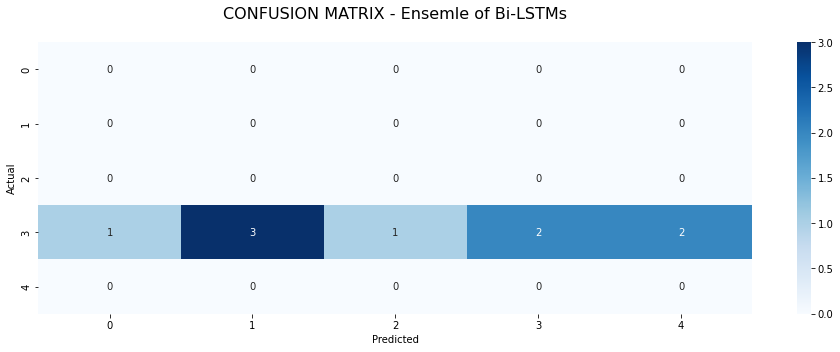

In [50]:
conf_mat=confusion_matrix(y_pred,y_test)

fig, ax = plt.subplots(figsize=(16,5))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Ensemle of Bi-LSTMs\n", size=16)